<a href="https://colab.research.google.com/github/SirichaiKhomleart/cognitive-systems-for-health-technology-applications/blob/master/Case_3_Patient_Drug_Review_(Sirichai_and_Puttiwat).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case 3. Patient Drug Review
Mr.Sirichai Khomleart<br>
Mr.Puttiwat Wanna<br>
Last edited: 17.04.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 0. Table of Contents
1. Objectives
2. Required Libraries
3. Data Description and Preprocessing
        3.1. Importing Datasets
        3.2. Converting Reviews into 3 Classes and Solving Unbalanced Classes
        3.3. Stemming Words
        3.4. Removing Stop Words
        3.5. Converting Reviews to Padded Sequences
        3.6. Convering labels to one-hot-categories
        3.7. Preparing Testing 
        3.8. Creating Only-selected-drug Data for Models in Part 4.3
        3.9. Declaring Helper Functions
4. Modeling and Compilation
        4.1. Model without Preprocessing Data
              4.1.1. Conv1D Model
              4.1.2. LSTM Model
              4.1.3. GRU Model
        4.2. Model with Preprocessing Data
              4.2.1. Conv1D Model
              4.2.2. LSTM Model
              4.2.3. GRU Model
        4.3. Model with Selected Drug Data
              4.3.1. GRU Model for Levonorgestrel Drug
              4.3.2. GRU Model for Etonogestrel Drug
5. Training and Validation
        5.1. Training Model without Preprocessing Data
              5.1.1. Conv1D Model
              5.1.2. LSTM Model
              5.1.3. GRU Model
        5.2. Training Model with Preprocessing Data
              5.2.1. Conv1D Model
              5.2.2. LSTM Model
              5.2.3. GRU Model
        5.3. Training Model with Selected Drug Data
              5.3.1. GRU Model for Levonorgestrel Drug
              5.3.2. GRU Model for Etonogestrel Drug
6. Evaluation
        6.1. Validation Comparison between Using Non-preprocessed Data and Preprocessed Data
        6.2. Test Scores for Best Selected Model
7. Results and Discussion
        7.1. Discussion about Preprocessing Data
        7.2. Discussion about Seperated Model for each Drug
        7.3. Discussion about Overfitting
8. Conclusions

## 1. Objectives

This case study aims for objectives as following
- Learn to build a model for classification texts and documents 
- Use Keras’ neural networks and other models to make an expert system to support doctors and pharmacists in order to analyze drug reviews.
- Understand the nature of models used to train with text data, including Conv1D, LSTM, GRU, etc.
- Understand how to preprocess text data input using different techniques.
- Learn about word stemming technque to find the root word to be used in this experiment study.
- Learn to test model architectures (number of filters, filter size, activation functions) and training settings (epochs, batch sizes, validation splits).
- Learn to make the documentation of the results clearly and in easily readable format.
- Learn to perform methods to improve accuracy of models. For example, regularization, drop out, etc




## 2. Required Libraries

We began our case study 3 by importing all neccessary libraries below.

In [0]:
#Required libraries for this case study

#basic libraries
%pylab inline
import time
from time import localtime, strftime
import cv2 #opencv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../content"))
import pickle
import warnings
warnings.filterwarnings("ignore") #Disable warnings
!pip install texttable
from texttable import Texttable # for creating table
import tensorflow as tf

#keras libraries
import keras
from keras import backend as K
from keras import models, layers
from keras import optimizers
from keras.models import Sequential
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Embedding, Flatten, Dense
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.regularizers import l1
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#sklearn libraries
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle #shuffle dataset
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve #ROC Curves
from sklearn.metrics import auc #AUC 
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report #For Analysis
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_fscore_support #For Calculation Scores
from sklearn.preprocessing import normalize #normalize dataset

#libraries for word preprocessing
import re # for cleaning data
from nltk.tokenize import sent_tokenize, word_tokenize #for word tokenization
from nltk.stem import PorterStemmer # for word stemming 
ps = PorterStemmer()

Populating the interactive namespace from numpy and matplotlib
['.config', 'drugsComTrain_raw.csv', 'drugsComTest_raw.csv', 'sample_data']
  Stored in directory: /root/.cache/pip/wheels/a7/4e/77/da46da4c5aece69b701cf45e6e4fe56ff98bfbdcc7b271d03b
Successfully built texttable


Using TensorFlow backend.


## 3. Data Description and Preprocessing


Throughout this case study, we used the dataset from https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018 provided by Jessica Li and her team as our main source of data.

<br>This dataset was used for the Winter 2018 Kaggle University Club Hackathon. The dataset is all about reviews and ratings of different kinds of drug, it contained around 16000 review texts from different drug users.

<br>This dataset contained two files listed below.
- *drugsComTest_raw.csv* This is CSV file for training and validation data. There are 7 columns describing the data.
  1. **uniqueID** Primary key for this table
  2. **drugName** Name of the drug reviewed by pateints/users
  3. **condition** Name of condition asscociated with patients/users that use the drug
  4. **review** Review text from patients/users
  5. **rating** Rating of drugs ranging from 1 to 10
  6. **date** Date of the review entry
  7. **usefulCount** Number of users who found this review useful
 
- *drugsComTrain_raw.csv* This is CSV file for testing data. There are 7 columns describing the data.
  1. **uniqueID** Primary key for this table
  2. **drugName** Name of the drug reviewed by pateints/users
  3. **condition** Name of condition asscociated with patients/users that use the drug
  4. **review** Review text from patients/users
  5. **rating** Rating of drugs ranging from 1 to 10
  6. **date** Date of the review entry
  7. **usefulCount** Number of users who found this review useful
  
  <br>Note that this study case will predict the rating of the drug into three categories. The data will be preprocessed from 10 class rating into three level rating labeled as 
  - -1 (negative review)
  - 0 (neutral review)
  - 1 (positive review)

### 3.1. Importing Datasets
<hr>

In [0]:
# Read the data
data = pd.read_csv('../content/drugsComTrain_raw.csv')
# Show the head of the data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [0]:
# Show data summary
data.describe()

,uniqueID,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [0]:
# Declare parameters for later use
dict_size = 750
data_size = 10000
label_size = 3
test_data_size = 2000

### 3.2. Converting Reviews into 3 Classes and Solving Unbalanced Classes
<hr>

To convert 10-class rating labels into **3-class rating labels**, we used average value (mean) and standard deviation (std) as criterias to set rating into new classes.
- Data that has rating *more than mean+(std/2)* will be categorized as class 1 (*positive review*).
- Data that has rating *between mean-(std/2) to mean+(std/2)* will be categorized as class 0 (*neutral review*).
- Data that has rating *less than mean-(std/2) *will be categorized as class -1 (*negative review*).

<br>The new rating value will be added to the dataset as a label column.

In [0]:
# Create labels based on the original article: Grässer et al. (2018)
r = data['rating']
labels = -1*(r <= 5.355) + 1*(r >= 8.625)\
# Add the label column to the data
data['label'] = labels
# Check the new data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,0
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,-1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,0
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1


In [0]:
# Count each label records
data['label'].value_counts()

 1    78520
-1    48088
 0    34689
Name: label, dtype: int64

You can see that we have **unbalanced classes problem**. Since unbalanced data can lead to biases in generating model for classification, we need to find a solution for this problem. To solve this, we introduced **class weight** to training data and used it for training model.

<br>Class weight in our algorithm uses sklearn compute_class_weight library to auto-calculate and generate appropiate weight for each class. The weight will be multiplied to the label later in the training process to make sure that data used to train the model will be balanced and unbiased. 

<br>Here are the code.



In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(data['label']), data['label'])
class_weights

array([1.11806826, 1.54993418, 0.6847385 ])

### 3.3. Stemming Words
<hr>
<br>In linguistic morphology and information retrieval, stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base, or root form—generally a written word form.

<br>This is to make sure that some words that have similar meaning and should be treated as the same importance will be processed properly. 

<br>For example, 'is', 'am', and 'are' will be replace by word 'be' and will be counted as the same index and have the same value as input data.

<br>Here are our code to stemming words.

In [0]:
# Declare preprocessing function
def preprocess_function(text):
  
  # Remove Unnescessary Characters
  text = re.sub("['0123456789']", '', text)
  text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r",", " ", text)
  text = re.sub(r"\.", " ", text)
  text = re.sub(r"!", " ", text)
  text = re.sub(r"\/", " ", text)
  text = re.sub(r"\^", " ", text)
  text = re.sub(r"\+", " ", text)
  text = re.sub(r"\-", " ", text)
  text = re.sub(r"\;", " ", text)
  text = re.sub(r"\:", " ", text)
  text = re.sub(r";", " ", text)
  text = re.sub(r":", " ", text)
  text = re.sub(r"\=", " ", text)
  text = re.sub(r"'", " ", text)
  text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
  text = re.sub(r":", " : ", text)
  text = re.sub(r" e g ", " eg ", text)
  text = re.sub(r" b g ", " bg ", text)
  text = re.sub(r" u s ", " american ", text)
  text = re.sub(r"\0s", "0", text)
  text = re.sub(r" 9 11 ", "911", text)
  text = re.sub(r"e - mail", "email", text)
  text = re.sub(r"j k", "jk", text)
  text = re.sub(r"\s{2,}", " ", text)
  s = text.lower()

  # Word Stemming
  wordcut = s.split(" ")
  for i in range(len(wordcut)):
    wordcut[i] = ps.stem(wordcut[i])
  sentence = ""
  for i in range(len(wordcut)):
    sentence = sentence+wordcut[i]+" "
    
  
  return sentence[:-1]

In [0]:
# Appiled preprocessing function to review texts
data['originalReview']=data['review']
data['review']=data['review'].apply(preprocess_function)
# Check data
data['review'].head(10)

0     it ha no side effect i take it in combin of b...
1     my son is halfway through hi fourth week of i...
2     i use to take anoth oral contracept which had...
3     thi is my first time use ani form of birth co...
4     suboxon ha complet turn my life around i feel...
5     nd day on mg start to work with rock hard ere...
6     he pull out but he cum a bit in me i took the...
7     abilifi chang my life there is hope i wa on z...
8     i ve had noth but problem with the keppera co...
9     i had been on the pill for mani year when my ...
Name: review, dtype: object

### 3.4. Removing Stop Words
<hr>
<br>A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. It's considered to be less important word (not help in term of classification) and not necessary to be process or include in the indexing list.

<br>We would not want these words taking up space in our database, or taking up valuable processing time.

<br>The list of stop word used in this experiment came from 3 sources.
- NLTK's list of english stopwords ([link](https://gist.github.com/sebleier/554280))
- Yoast team ([link](https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js))
- Rank NL ([link](https://www.ranks.nl/stopwords))

<br>Since we already stemmed word in the review text, we decided to stem stop word list too to have larger stop word list that can be match the stemmed review text.

<br>Here are our entire code what we've done.

In [0]:
# Declare stopwords list
stop_word = ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder","a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount", "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as", "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the","a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p",
"q", "r", "s", "t", "u", "v", "w", "x", "y", "z","A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z",'co','op','research-articl', 'pagecount','cit','ibid','les','le','au','que','est','pas','vol','el','los','pp','u201d','well-b', 'http', 'volumtype', 'par', '0o', '0s', '3a', '3b', '3d', '6b', '6o', 'a1', 'a2', 'a3', 'a4', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'aj', 'al', 'an', 'ao', 'ap', 'ar', 'av', 'aw', 'ax', 'ay', 'az', 'b1', 'b2', 'b3', 'ba', 'bc', 'bd', 'be', 'bi', 'bj', 'bk', 'bl', 'bn', 'bp', 'br', 'bs', 'bt', 'bu', 'bx', 'c1', 'c2', 'c3', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'cl', 'cm', 'cn', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cx', 'cy', 'cz', 'd2', 'da', 'dc', 'dd', 'de', 'df', 'di', 'dj', 'dk', 'dl', 'do', 'dp', 'dr', 'ds', 'dt', 'du', 'dx', 'dy', 'e2', 'e3', 'ea', 'ec', 'ed', 'ee', 'ef', 'ei', 'ej', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ex', 'ey', 'f2', 'fa', 'fc', 'ff', 'fi', 'fj', 'fl', 'fn', 'fo', 'fr', 'fs', 'ft', 'fu', 'fy', 'ga', 'ge', 'gi', 'gj', 'gl', 'go', 'gr', 'gs', 'gy', 'h2', 'h3', 'hh', 'hi', 'hj', 'ho', 'hr', 'hs', 'hu', 'hy', 'i', 'i2', 'i3', 'i4', 'i6', 'i7', 'i8', 'ia', 'ib', 'ic', 'ie', 'ig', 'ih', 'ii', 'ij', 'il', 'in', 'io', 'ip', 'iq', 'ir', 'iv', 'ix', 'iy', 'iz', 'jj', 'jr', 'js', 'jt', 'ju', 'ke', 'kg', 'kj', 'km', 'ko', 'l2', 'la', 'lb', 'lc', 'lf', 'lj', 'ln', 'lo', 'lr', 'ls', 'lt', 'm2', 'ml', 'mn', 'mo', 'ms', 'mt', 'mu', 'n2', 'nc', 'nd', 'ne', 'ng', 'ni', 'nj', 'nl', 'nn', 'nr', 'ns', 'nt', 'ny', 'oa', 'ob', 'oc', 'od', 'of', 'og', 'oi', 'oj', 'ol', 'om', 'on', 'oo', 'oq', 'or', 'os', 'ot', 'ou', 'ow', 'ox', 'oz', 'p1', 'p2', 'p3', 'pc', 'pd', 'pe', 'pf', 'ph', 'pi', 'pj', 'pk', 'pl', 'pm', 'pn', 'po', 'pq', 'pr', 'ps', 'pt', 'pu', 'py', 'qj', 'qu', 'r2', 'ra', 'rc', 'rd', 'rf', 'rh', 'ri', 'rj', 'rl', 'rm', 'rn', 'ro', 'rq', 'rr', 'rs', 'rt', 'ru', 'rv', 'ry', 's2', 'sa', 'sc', 'sd', 'se', 'sf', 'si', 'sj', 'sl', 'sm', 'sn', 'sp', 'sq', 'sr', 'ss', 'st', 'sy', 'sz', 't1', 't2', 't3', 'tb', 'tc', 'td', 'te', 'tf', 'th', 'ti', 'tj', 'tl', 'tm', 'tn', 'tp', 'tq', 'tr', 'ts', 'tt', 'tv', 'tx', 'ue', 'ui', 'uj', 'uk', 'um', 'un', 'uo', 'ur', 'ut', 'va', 'wa', 'vd', 'wi', 'vj', 'vo', 'wo', 'vq', 'vt', 'vu', 'x1', 'x2', 'x3', 'xf', 'xi', 'xj', 'xk', 'xl', 'xn', 'xo', 'xs', 'xt', 'xv', 'xx', 'y2', 'yj', 'yl', 'yr', 'ys', 'yt', 'zi', 'zz']

In [0]:
# Add stemmed stopword to stopword list
list_stop_words_stemmed = []
for sw in stop_word:
  originalsw = sw
  list_stop_words_stemmed.append(originalsw)
  preprosw = preprocess_function(sw)
  if (originalsw != preprosw[:-1]):
    list_stop_words_stemmed.append(preprosw[:-1])
new_swords = frozenset(list_stop_words_stemmed)

In [0]:
# Declare stopword removing function
def remove_sword(text):
    text_split = text.split(' ')
    return_text = ''
    for word in text_split:
        if word in new_swords:
            return_text = return_text
        else:
            return_text = return_text + ' '+ word
    return return_text

In [0]:
# Appiled stopword removing function to review texts
data['review']=data['review'].apply(remove_sword)
# Check data
data['review'].head(10)

0                               combin bystol fish oil
1     son halfway fourth week intuniv becam concern...
2     anoth oral contracept pill cycl veri happi ve...
3     time ani form birth control glad patch month ...
4     suboxon complet turn life feel healthier exce...
5     day start work rock hard erect howev experian...
6     pull cum bit plan hour pregnanc test week pre...
7     abilifi chang life hope zoloft clonidin start...
8     noth problem keppera constant shake arm amp l...
9     pill mani year doctor chang rx chateal realli...
Name: review, dtype: object

### 3.5. Converting Reviews to Padded Sequences
<hr>

<br>Since our model cannot process word directly, we need to convert the review text into appropiated format.

<br>Deep learning libraries assume a vectorized representation of the data. So first, we will tokenize the text into indexed-list with tokenizer and fit_on_text libraries. This will generate the index-list document to represent review text in form of vectors instead of string. This vectorization allows code to efficiently perform the matrix operations in batch for chosen deep learning algorithms.

<br>However, in the case of variable length sequence prediction problems, it requires that data need to be transformed such that each sequence has the same length. We solve this problem with the pad_sequence libraries that will generate zero for document that has length less than the others.

<br>Here are the algorithm.

In [0]:
# Read a part of the reviews and create training sequences (x_train)

#for non-preprocessed data
samples_nonpre = data['originalReview'].iloc[:data_size]
tokenizer_nonpre = Tokenizer(num_words = dict_size)
tokenizer_nonpre.fit_on_texts(samples_nonpre)
sequences_nonpre = tokenizer_nonpre.texts_to_sequences(samples_nonpre)
x_train_nonpre = pad_sequences(sequences_nonpre, maxlen = 500)

# for preprocessed data
samples = data['review'].iloc[:data_size]
tokenizer = Tokenizer(num_words = dict_size)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
x_train = pad_sequences(sequences, maxlen = 500)

In [0]:
#cheack result
samples.head()

0                               combin bystol fish oil
1     son halfway fourth week intuniv becam concern...
2     anoth oral contracept pill cycl veri happi ve...
3     time ani form birth control glad patch month ...
4     suboxon complet turn life feel healthier exce...
Name: review, dtype: object

###3.6. Convert labels to one-hot-categories
<hr>

<br>Same as the training information, its labels need to be in form of vector too. We use one-hot representation in this case to help us transform 3 classes labels into vector of binary values.

<br>Here is the code.

In [0]:
# Convert the labels to one_hot_category values
one_hot_labels = to_categorical(labels[:data_size], num_classes = label_size)

In [0]:
# Check the training and label sets
x_train.shape, one_hot_labels.shape

((10000, 500), (10000, 3))

### 3.7. Preparing Testing Data
<hr>

<br>Next, we import the test dataset and do as the same as training dataset.

In [0]:
# Read the data
test_data = pd.read_csv('../content/drugsComTest_raw.csv')
# Show the head of the data
test_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [0]:
# Create labels based on the original article: Grässer et al. (2018)
r = test_data['rating']
labels_test = -1*(r <= 5.355) + 1*(r >= 8.625)

# Add the label column to the data
test_data['label'] = labels_test

# Calculating Class Weight
class_weights_test = class_weight.compute_class_weight('balanced', np.unique(test_data['label']), test_data['label'])

# Appiled preprocessing function to review texts
test_data['originalReview']=test_data['review']
test_data['review']=test_data['review'].apply(preprocess_function)

# Appiled stopword removing function to review texts
test_data['review']=test_data['review'].apply(remove_sword)

# Converting reviews to padded sequences
test_data = test_data.iloc[:test_data_size]
samples_test = test_data['review']
tokenizer_test = Tokenizer(num_words = dict_size)
tokenizer_test.fit_on_texts(samples_test)
sequences_test = tokenizer_test.texts_to_sequences(samples_test)
x_test = pad_sequences(sequences_test, maxlen = 500)

# Convert the labels to one_hot_category values
labels_test = test_data['label']
one_hot_labels_test = to_categorical(labels_test[:test_data_size], num_classes = label_size)

# Check dataset
test_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,label,originalReview
0,163740,Mirtazapine,Depression,tri antidepress year citalopram fluoxetin ami...,10,28-Feb-12,22,1,"""I&#039;ve tried a few antidepressants over th..."
1,206473,Mesalamine,"Crohn's Disease, Maintenance",son crohn diseas veri asacol complaint mani t...,8,17-May-09,17,0,"""My son has Crohn&#039;s disease and has done ..."
2,159672,Bactrim,Urinary Tract Infection,quick reduct symptom,9,29-Sep-17,3,1,"""Quick reduction of symptoms"""
3,39293,Contrave,Weight Loss,contrav combin drug alcohol smoke opioid cess...,9,5-Mar-17,35,1,"""Contrave combines drugs that were used for al..."
4,97768,Cyclafem 1 / 35,Birth Control,birth control cycl read review type birth con...,9,22-Oct-15,4,1,"""I have been on this birth control for one cyc..."


In [0]:
# Check training output
x_test

array([[  0,   0,   0, ..., 446,  64, 245],
       [  0,   0,   0, ..., 108, 187, 252],
       [  0,   0,   0, ...,   0, 518,  65],
       ...,
       [  0,   0,   0, ...,  62,  19, 465],
       [  0,   0,   0, ..., 529,  94, 140],
       [  0,   0,   0, ..., 439,  58,  23]], dtype=int32)

In [0]:
# Check label output
one_hot_labels_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [0]:
len(one_hot_labels_test)

2000

### 3.8. Creating Only-selected-drug Data for Models in Part 4.3
<hr>
<br>In our experiment, we believed that seperating data to train model for each drug individually will result in the better model with higher accuracy and lower loss. 

<br>For example, we extract the Levenorgestrel drug review records to the new dataset and train model based on only this drug review. We think it will be better than use all dataset with different kind of drugs mixed together to train our model since the review information also based on type of drugs as well.

<br>So, we experiment by seperate 2 new datasets that contain only Levenorgestrel drug and Etonogestrel drug review record respectively and train these two model individually.

In [0]:
#Check how many drug we have and the number of record based on drug name
data.groupby('drugName').nunique().sort_values(by=['uniqueID'],ascending=False).head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,label,originalReview
drugName,,,,,,,,,
Levonorgestrel,3657,1,4,3653,10,1603,93,3,3656
Etonogestrel,3336,1,2,3336,10,1659,77,3,3336
Ethinyl estradiol / norethindrone,2850,1,8,2849,10,1664,70,3,2849
Nexplanon,2156,1,7,2156,10,1050,53,3,2156
Ethinyl estradiol / norgestimate,2117,1,6,2115,10,1418,67,3,2115
Ethinyl estradiol / levonorgestrel,1888,1,7,1887,10,1328,56,3,1887
Phentermine,1543,1,3,1543,10,1177,150,3,1543
Sertraline,1360,1,18,1360,10,1052,172,3,1360
Escitalopram,1292,1,13,1289,10,1036,171,3,1291


In [0]:
# Select data only from drug name Levonorgestrel
drugName = "Levonorgestrel"
datalevo = data.loc[data['drugName'] == drugName]
# Check the number of records
datalevo_size = len(datalevo)
print(drugName, datalevo_size)

# Appiled preprocessing function to review texts
datalevo['originalReview']=datalevo['review']
datalevo['review']=datalevo['review'].apply(preprocess_function)

# Appiled stopword removing function to review texts
datalevo['review']=datalevo['review'].apply(remove_sword)

# Converting reviews to padded sequences
samples_levo = datalevo['review']
tokenizer_levo = Tokenizer(num_words = dict_size)
tokenizer_levo.fit_on_texts(samples_levo)
sequences_levo = tokenizer_levo.texts_to_sequences(samples_levo)
x_train_levo = pad_sequences(sequences_levo, maxlen = 500)

# Convert the labels to one_hot_category values
labels_levo = datalevo['label']
one_hot_labels_levo = to_categorical(labels_levo[:datalevo_size], num_classes = label_size)

# Preparing Test Data for this Model
test_datalevo = test_data.loc[test_data['drugName'] == drugName]
if (len(test_datalevo)<500):
  test_data_size = len(test_datalevo)
else:
  test_data_size = 500
test_datalevo = test_datalevo.iloc[:test_data_size]
samples_test_levo = test_datalevo['review']
tokenizer_test_levo = Tokenizer(num_words = dict_size)
tokenizer_test_levo.fit_on_texts(samples_test_levo)
sequences_test_levo = tokenizer_test_levo.texts_to_sequences(samples_test_levo)
x_test_levo = pad_sequences(sequences_test_levo, maxlen = 500)
labels_test_levo = test_datalevo['label']
one_hot_labels_test_levo = to_categorical(labels_test_levo[:test_data_size], num_classes = label_size)

# Check dataset
datalevo.head()

Levonorgestrel 3657


,uniqueID,drugName,condition,review,rating,date,usefulCount,label,originalReview
6,165907,Levonorgestrel,Emergency Contraception,pull cum bit plan hour pregnanc test week pre...,1,7-Mar-17,5,-1,pull cum bit plan hour pregnanc test week pre...
83,131041,Levonorgestrel,Birth Control,mirena year ago insert breez cramp period rem...,1,18-Jan-10,10,-1,mirena year ago insert breez cramp period rem...
113,166891,Levonorgestrel,Birth Control,time skyla absolut breez skyla togeth sinc oc...,10,14-Jul-16,1,1,time skyla absolut breez skyla togeth sinc oc...
139,130867,Levonorgestrel,Birth Control,kid child born suffer daili tension migrain h...,2,26-Jun-11,2,-1,kid child born suffer daili tension migrain h...
144,165523,Levonorgestrel,Birth Control,liletta insert novemb process bad numb inject...,3,24-May-17,4,-1,liletta insert novemb process overal bad numb...


In [0]:
# Check training output
x_train_levo

array([[  0,   0,   0, ...,  94,   8,  30],
       [  0,   0,   0, ...,  14,  14,  34],
       [  0,   0,   0, ...,   4, 661, 205],
       ...,
       [  0,   0,   0, ...,  87, 148, 114],
       [  0,   0,   0, ..., 604, 447,  71],
       [  0,   0,   0, ...,  41,  28,  86]], dtype=int32)

In [0]:
# Check label output
one_hot_labels_levo

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [0]:
# Select data only from drug name Levonorgestrel
drugName = "Etonogestrel"
dataeto = data.loc[data['drugName'] == drugName]
# Check the number of records
dataeto_size = len(dataeto)
print(drugName, dataeto_size)

# Appiled preprocessing function to review texts
dataeto['originalReview']=dataeto['review']
dataeto['review']=dataeto['review'].apply(preprocess_function)

# Appiled stopword removing function to review texts
dataeto['review']=dataeto['review'].apply(remove_sword)

# Converting reviews to padded sequences
samples_eto = dataeto['review']
tokenizer_eto = Tokenizer(num_words = dict_size)
tokenizer_eto.fit_on_texts(samples_eto)
sequences_eto = tokenizer_eto.texts_to_sequences(samples_eto)
x_train_eto = pad_sequences(sequences_eto, maxlen = 500)

# Convert the labels to one_hot_category values
labels_eto = dataeto['label']
one_hot_labels_eto = to_categorical(labels_eto[:dataeto_size], num_classes = label_size)

# Preparing Test Data for this Model
test_dataeto = test_data.loc[test_data['drugName'] == drugName]
if (len(test_dataeto)<500):
  test_data_size = len(test_dataeto)
else:
  test_data_size = 500
test_dataeto = test_dataeto.iloc[:test_data_size]
samples_test_eto = test_dataeto['review']
tokenizer_test_eto = Tokenizer(num_words = dict_size)
tokenizer_test_eto.fit_on_texts(samples_test_eto)
sequences_test_eto = tokenizer_test_eto.texts_to_sequences(samples_test_eto)
x_test_eto = pad_sequences(sequences_test_eto, maxlen = 500)
labels_test_eto = test_dataeto['label']
one_hot_labels_test_eto = to_categorical(labels_test_eto[:test_data_size], num_classes = label_size)

# Check dataset
dataeto.head()

Etonogestrel 3336


,uniqueID,drugName,condition,review,rating,date,usefulCount,label,originalReview
22,227020,Etonogestrel,Birth Control,nexplanon doe job worri free sex onli thing p...,9,11-Aug-14,11,1,nexplanon doe job worri free sex onli thing p...
74,144224,Etonogestrel,Birth Control,experi dure nexplon great pregnanc onli issu ...,10,27-May-16,1,1,experi dure nexplon great pregnanc onli issu ...
123,144777,Etonogestrel,Birth Control,birth control gain replac gain weight bare pe...,3,27-Jan-16,0,-1,birth control gain replac gain weight bare pe...
138,227293,Etonogestrel,Birth Control,absolut love nexplanon ladi super hesit trine...,9,29-Sep-13,8,1,absolut love nexplanon ladi super hesit trine...
152,143971,Etonogestrel,Birth Control,year nexplanon problem bled month straight ve...,5,8-Aug-16,6,-1,year nexplanon problem bled month straight ve...


In [0]:
# Check training output
x_train_eto

array([[  0,   0,   0, ...,  11,  10, 188],
       [  0,   0,   0, ..., 383,  24,  71],
       [  0,   0,   0, ...,  14, 242, 118],
       ...,
       [  0,   0,   0, ...,   3, 104, 605],
       [  0,   0,   0, ...,  26, 391,  58],
       [  0,   0,   0, ...,  43,  37, 207]], dtype=int32)

In [0]:
# Check label output
one_hot_labels_eto

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### 3.9. Declare Helper Functions
<hr>
<br>Next, we declare function use to train model and print out matrix scores and graphs.

In [0]:
# Similarly create a function for model training, for demonstration purposes we use constant values

score_list = []

def train_model(model_name, model, x, y, e = 10, bs = 32, v = 1, vs = 0.25):
  
    # Save the model giving best validation loss
    cb = ModelCheckpoint('bestmodel_'+model_name+'.h5', 
                          monitor = 'val_loss', 
                          verbose = 0, 
                          save_best_only = True)
    
    # Declare Early Stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    # Start timing
    start = time.time()
    
    # Create validation set, equally split dataset into traning set and validation set for all labels
    stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=vs, random_state=42)
    for train_dat,test_dat in stratSplit.split(x, y):
        X_train = x[train_dat]
        y_train = y[train_dat]
        X_val = x[test_dat]
        y_val = y[test_dat]
#     set_of_train = pd.concat([X_train, y_train], axis=1)
#     set_of_val = pd.concat([X_val, y_val], axis=1)

    # Training
    print('Training the model ...')
#     h = model.fit(x, y, epochs = e, batch_size = bs, verbose = v, validation_split = vs, callbacks = [cb],class_weight=class_weights)
    h = model.fit(X_train, y_train, epochs = e, batch_size = bs, verbose = v, validation_data=(X_val, y_val), callbacks = [cb],class_weight=class_weights)
    stop = time.time()
    etime = stop - start
    print('Training done, time used is '+str(etime))

    # Update the initial epoch, used for saving the previous trainings, if trained several times
    model.save('model_'+model_name+'.h5')
    print("")
    
    # Save the history
    import pickle
    with open('history_'+model_name, 'wb') as file_pi:
        pickle.dump(h.history, file_pi)
        
    # Load best model
    loadedmodel = load_model('model_'+model_name+'.h5')
    
    print('Calculating Final Model Scores :')
    
    # Print total accuracy and confusion matrix
    val_predicts = loadedmodel.predict(X_val)
    y_pred = argmax(val_predicts, axis = 1)
    labels_test_argmax = argmax(y_val, axis = 1)
    cm = confusion_matrix(labels_test_argmax, y_pred)
#     score = loadedmodel.evaluate(x_test, one_hot_labels_test, batch_size=32)
    print('--------------------Final Model Scores--------------------')
#     print('Validation loss:', score[0])
#     print('Validation accuracy:', score[1])
    print('Total accuracy: {:.4f}'.format(np.trace(cm)/sum(cm)))
    print('Confusion matrix:')
    print(cm)

    # Calculate precision, recall, fscore and support
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p, r, f, s = precision_recall_fscore_support(labels_test_argmax, y_pred)
        
    # Print precision, recall, fscore and support  
    np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
    print('Support: ', s)
    print('Precision:', p)
    print('Recall:   ', r)
    print('F-score:  ', f)
    print('---------------------------------------------------------')
    print('')
    
    # Load final model
    loadedmodel = load_model('bestmodel_'+model_name+'.h5')
    
    print('Calculating Best Model Scores :')
    
    # Print total accuracy and confusion matrix
    val_predicts = loadedmodel.predict(X_val)
    y_pred = argmax(val_predicts, axis = 1)
    labels_test_argmax = argmax(y_val, axis = 1)
    cm = confusion_matrix(labels_test_argmax, y_pred)
#     score = loadedmodel.evaluate(x_test, one_hot_labels_test, batch_size=32)
    print('--------------------Best Model Scores--------------------')
#     print('Validation loss:', score[0])
#     print('Validation accuracy:', score[1])
    print('Total accuracy: {:.4f}'.format(np.trace(cm)/sum(cm)))
    print('Confusion matrix:')
    print(cm)

    # Calculate precision, recall, fscore and support
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p, r, f, s = precision_recall_fscore_support(labels_test_argmax, y_pred)
        
    # Print precision, recall, fscore and support  
    np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
    print('Support: ', s)
    print('Precision:', p)
    print('Recall:   ', r)
    print('F-score:  ', f)
    print('---------------------------------------------------------')
    print('')
    
    score_list.append([model_name,cm,s,p,r,f])
    
    return h

In [0]:
# We use the same plotting commands several times, so create a function for that purpose
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## 4. Modeling and compilation

<br>As we stated earlier, we will try different methods and compare the results to find the best and most accurate model for classify drug review into 3 rating categories. 

<br>In this case study, we want to compare how model can be improve with preprocessed data and without preprocessed them. Here are models we will use to perform in this experiment.

1. **Conv1D model with non-preprocessed data**
2. **LSTM model with non-preprocessed data**
3. **GRU model with non-preprocessed data**
<br>
<br>
4. **Conv1D model with preprocessed data**
5. **LSTM model with preprocessed data**
6. **GRU model with preprocessed data**

<br>We will use these three models to train for both preprocessed data and non-preprocessed data. The result will be clarify and discuss in the discusiion part.

<br>Moreover, we want to experiment to seperating data to train model for each drug individually. So, we experiment by seperate 2 new datasets that contain only Levenorgestrel drug and Etonogestrel drug review record respectively and train two model based on these two datasets individually.

6. **GRU Model with only Levonorgestrel drug data**
6. **GRU Model with only Etonogestrel drug data**

<br>Here below is how we construct our model.

###4.1. Model without Preprocessing Data

#### 4.1.1. Conv1D Model

In [0]:
m1 = Sequential()
m1.add(Embedding(1000, 32, input_length = 500))
m1.add(Conv1D(32, 7, activation = 'relu'))
m1.add(Conv1D(64, 7, activation = 'relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(64, 7, activation = 'relu'))
m1.add(Conv1D(32, 7, activation = 'relu'))
m1.add(GlobalMaxPooling1D())
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           7200      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 488, 64)           14400     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 91, 64)            28736     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 85, 32)            14368     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
__________

#### 4.1.2. LSTM Model

In [0]:
m2 = Sequential()
m2.add(Embedding(1000, 16, input_length = 500))
m2.add(LSTM(32,activity_regularizer=l1(0.001)))
m2.add(Dense(3, activation = 'softmax'))
m2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           16000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 22,371
Trainable params: 22,371
Non-trainable params: 0
_________________________________________________________________


#### 4.1.3. GRU Model

In [0]:
m3 = Sequential()
m3.add(Embedding(1000, 8, input_length = 500))
m3.add(GRU(8, dropout = 0.2, recurrent_dropout = 0.2))
m3.add(Dense(3, activation = 'softmax'))
m3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 8,435
Trainable params: 8,435
Non-trainable params: 0
_________________________________________________________________


### 4.2. Model with Preprocessing Data

#### 4.2.1. Conv1D Model

In [0]:
m4 = Sequential()
m4.add(Embedding(1000, 32, input_length = 500))
m4.add(Conv1D(32, 7, activation = 'relu'))
m4.add(Conv1D(64, 7, activation = 'relu'))
m4.add(MaxPooling1D(5))
m4.add(Conv1D(64, 7, activation = 'relu'))
m4.add(Conv1D(32, 7, activation = 'relu'))
m4.add(GlobalMaxPooling1D())
m4.add(Dense(3, activation = 'softmax'))
m4.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           7200      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 488, 64)           14400     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 91, 64)            28736     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 85, 32)            14368     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
__________

#### 4.2.2. LSTM Model

In [0]:
m5 = Sequential()
m5.add(Embedding(1000, 16, input_length = 500))
m5.add(LSTM(32,activity_regularizer=l1(0.001)))
m5.add(Dense(3, activation = 'softmax'))
m5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           16000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 22,371
Trainable params: 22,371
Non-trainable params: 0
_________________________________________________________________


#### 4.2.3. GRU Model

In [0]:
m6 = Sequential()
m6.add(Embedding(1000, 8, input_length = 500))
m6.add(GRU(8, dropout = 0.2, recurrent_dropout = 0.2))
m6.add(Dense(3, activation = 'softmax'))
m6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 8,435
Trainable params: 8,435
Non-trainable params: 0
_________________________________________________________________


### 4.3. Model with Selected Drug Data

#### 4.3.1. GRU Model for Levonorgestrel Drug

In [0]:
m7 = Sequential()
m7.add(Embedding(1000, 8, input_length = 500))
m7.add(GRU(8, dropout = 0.2, recurrent_dropout = 0.2))
m7.add(Dense(3, activation = 'softmax'))
m7.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 8,435
Trainable params: 8,435
Non-trainable params: 0
_________________________________________________________________


#### 4.3.2. GRU Model for Etonogestrel Drug

In [0]:
m8 = Sequential()
m8.add(Embedding(1000, 8, input_length = 500))
m8.add(GRU(8, dropout = 0.2, recurrent_dropout = 0.2))
m8.add(Dense(3, activation = 'softmax'))
m8.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 8,435
Trainable params: 8,435
Non-trainable params: 0
_________________________________________________________________


## 5. Training and Validation
<br>In this section, we will train each model and find out the score for the final model and the best model for each method.


<br>We train each model with training flow we have prepared and validate them with our validation data that split from training set for 25%. For each method, we will set call back to save the best model (decided by looking at the validation loss) to files for later use.

<br>For the final model in each method, we save to the file name 'model_x.h5'. For the best model in each method, we save to thr file name 'bestmodel_x.h5'.

<br>Here is our code for training each model, find matrix scores like a confusion matrix and model accuracy, and plotting graphical representation comparing between accuracy with epoch and loss with epoch.

### 5.1. Model without Preprocessing Data

####  5.1.1. Conv1D Model

Training the model ...
Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 30s 4ms/step - loss: 1.0358 - acc: 0.4867 - val_loss: 0.9994 - val_acc: 0.5172
Epoch 2/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.9419 - acc: 0.5697 - val_loss: 0.9724 - val_acc: 0.5712
Epoch 3/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.8631 - acc: 0.6215 - val_loss: 1.0466 - val_acc: 0.5652
Epoch 4/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.8146 - acc: 0.6423 - val_loss: 0.9078 - val_acc: 0.6156
Epoch 5/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.7692 - acc: 0.6727 - val_loss: 0.9099 - val_acc: 0.6068
Epoch 6/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.7178 - acc: 0.6869 - val_loss: 0.9616 - val_acc: 0.5824
Epoch 7/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.6637 - acc: 0.7175 - val_loss: 1.0013 - 

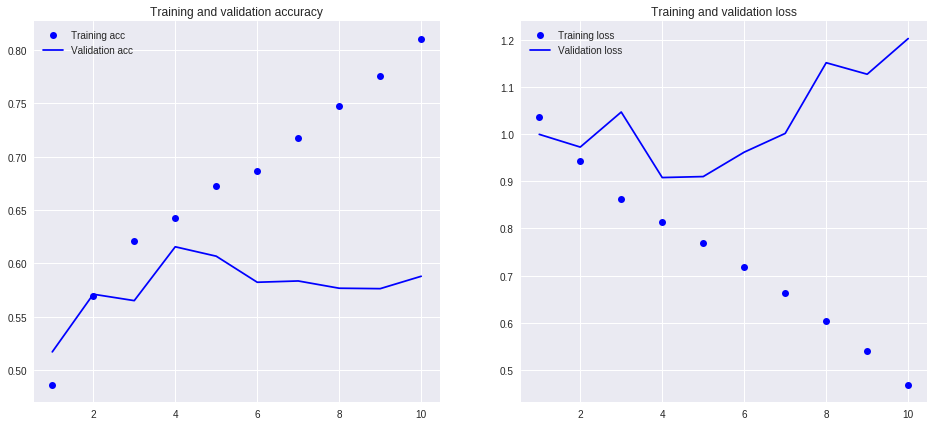

In [0]:
h1 = train_model('1',m1, x_train_nonpre, one_hot_labels)
plot_history(h1)

In [0]:
del m1
del h1
tf.reset_default_graph()
K.clear_session()

#### 5.1.2. LSTM Model

Training the model ...
Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 67s 9ms/step - loss: 1.0452 - acc: 0.5164 - val_loss: 0.9663 - val_acc: 0.6056
Epoch 2/10
7500/7500 [==============================] - 67s 9ms/step - loss: 0.9259 - acc: 0.6224 - val_loss: 0.9170 - val_acc: 0.6252
Epoch 3/10
7500/7500 [==============================] - 67s 9ms/step - loss: 0.8730 - acc: 0.6439 - val_loss: 0.8894 - val_acc: 0.6356
Epoch 4/10
7500/7500 [==============================] - 66s 9ms/step - loss: 0.8449 - acc: 0.6573 - val_loss: 1.1397 - val_acc: 0.5716
Epoch 5/10
7500/7500 [==============================] - 66s 9ms/step - loss: 0.8244 - acc: 0.6659 - val_loss: 0.9206 - val_acc: 0.6108
Epoch 6/10
7500/7500 [==============================] - 67s 9ms/step - loss: 0.8036 - acc: 0.6736 - val_loss: 0.9042 - val_acc: 0.6312
Epoch 7/10
7500/7500 [==============================] - 66s 9ms/step - loss: 0.7907 - acc: 0.6803 - val_loss: 0.8944 - 

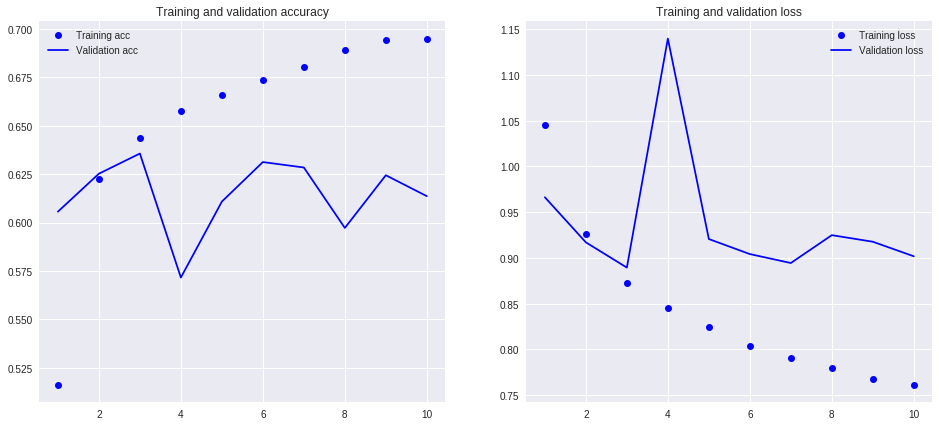

In [0]:
h2 = train_model('2', m2, x_train_nonpre, one_hot_labels)
plot_history(h2)

In [0]:
del m2
del h2
tf.reset_default_graph()
K.clear_session()

#### 5.1.3. GRU Model

Training the model ...
Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 59s 8ms/step - loss: 1.0482 - acc: 0.4852 - val_loss: 1.0339 - val_acc: 0.4868
Epoch 2/10
7500/7500 [==============================] - 58s 8ms/step - loss: 1.0237 - acc: 0.4868 - val_loss: 1.0177 - val_acc: 0.4872
Epoch 3/10
7500/7500 [==============================] - 57s 8ms/step - loss: 0.9924 - acc: 0.5129 - val_loss: 0.9911 - val_acc: 0.5212
Epoch 4/10
7500/7500 [==============================] - 57s 8ms/step - loss: 0.9518 - acc: 0.5616 - val_loss: 0.9748 - val_acc: 0.5344
Epoch 5/10
7500/7500 [==============================] - 57s 8ms/step - loss: 0.9176 - acc: 0.5875 - val_loss: 0.9487 - val_acc: 0.5636
Epoch 6/10
7500/7500 [==============================] - 58s 8ms/step - loss: 0.8942 - acc: 0.6047 - val_loss: 0.9363 - val_acc: 0.5780
Epoch 7/10
7500/7500 [==============================] - 58s 8ms/step - loss: 0.8841 - acc: 0.6116 - val_loss: 0.9273 - 

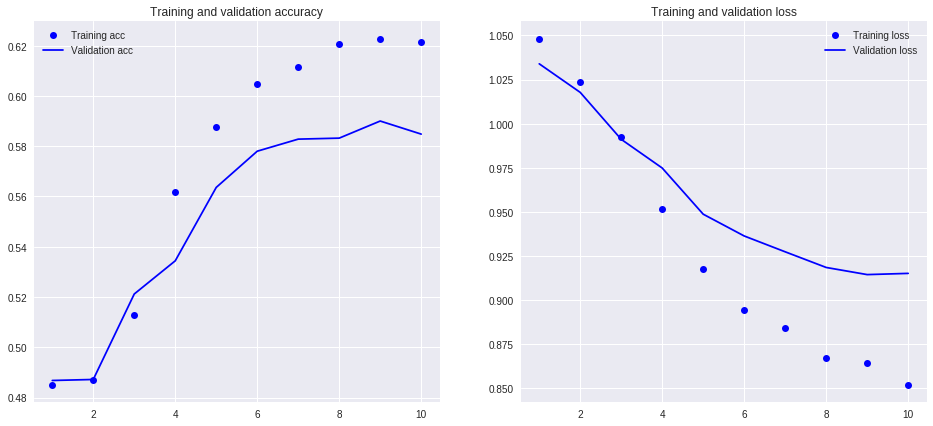

In [0]:
h3 = train_model('3',m3, x_train_nonpre, one_hot_labels)
plot_history(h3)

In [0]:
del m3
del h3
tf.reset_default_graph()
K.clear_session()

### 5.2. Model with Preprocessing Data

#### 5.2.1. Conv1D Model

Training the model ...
Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 30s 4ms/step - loss: 1.0233 - acc: 0.5032 - val_loss: 0.9751 - val_acc: 0.5512
Epoch 2/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.9290 - acc: 0.5815 - val_loss: 0.9553 - val_acc: 0.5656
Epoch 3/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.8899 - acc: 0.6081 - val_loss: 0.9332 - val_acc: 0.5836
Epoch 4/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.8646 - acc: 0.6217 - val_loss: 1.0017 - val_acc: 0.5688
Epoch 5/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.8342 - acc: 0.6321 - val_loss: 0.9575 - val_acc: 0.5712
Epoch 6/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.8016 - acc: 0.6504 - val_loss: 0.9731 - val_acc: 0.5784
Epoch 7/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.7575 - acc: 0.6697 - val_loss: 1.1101 - 

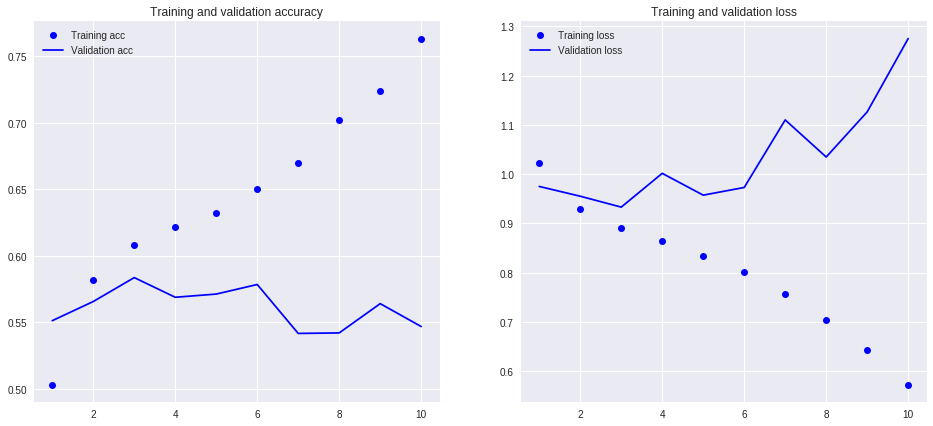

In [0]:
h4 = train_model('4',m4, x_train, one_hot_labels)
plot_history(h4)

In [0]:
del m4
del h4
tf.reset_default_graph()
K.clear_session()

#### 5.2.2. LSTM Model

Training the model ...
Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 68s 9ms/step - loss: 1.0245 - acc: 0.5409 - val_loss: 0.9572 - val_acc: 0.5940
Epoch 2/10
7500/7500 [==============================] - 66s 9ms/step - loss: 0.9211 - acc: 0.6129 - val_loss: 0.9320 - val_acc: 0.5972
Epoch 3/10
7500/7500 [==============================] - 66s 9ms/step - loss: 0.8909 - acc: 0.6281 - val_loss: 0.9301 - val_acc: 0.6008
Epoch 4/10
7500/7500 [==============================] - 66s 9ms/step - loss: 0.8712 - acc: 0.6325 - val_loss: 0.9188 - val_acc: 0.6000
Epoch 5/10
7500/7500 [==============================] - 66s 9ms/step - loss: 0.8528 - acc: 0.6404 - val_loss: 0.9180 - val_acc: 0.6040
Epoch 6/10
7500/7500 [==============================] - 67s 9ms/step - loss: 0.8358 - acc: 0.6552 - val_loss: 0.9197 - val_acc: 0.6036
Epoch 7/10
7500/7500 [==============================] - 66s 9ms/step - loss: 0.8210 - acc: 0.6593 - val_loss: 0.9349 - 

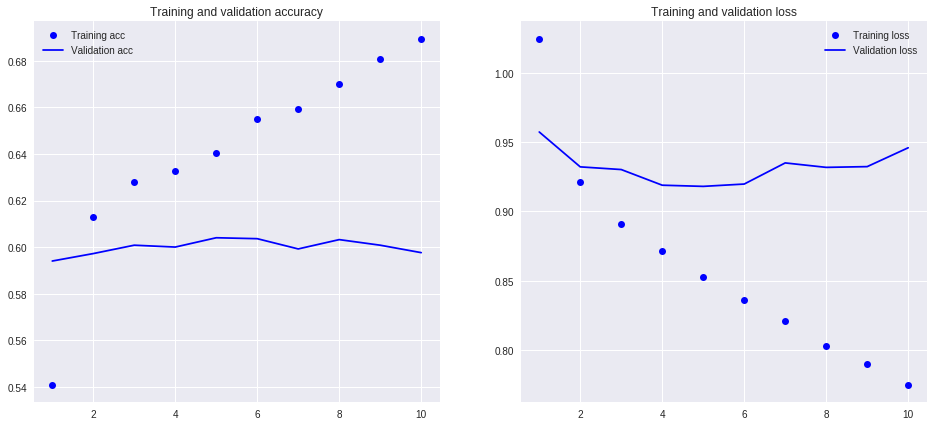

In [0]:
h5 = train_model('5', m5, x_train, one_hot_labels)
plot_history(h5)

In [0]:
del m5
del h5
tf.reset_default_graph()
K.clear_session()

#### 5.2.3. GRU Model

Training the model ...
Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 59s 8ms/step - loss: 1.0366 - acc: 0.4851 - val_loss: 1.0142 - val_acc: 0.4868
Epoch 2/10
7500/7500 [==============================] - 57s 8ms/step - loss: 0.9804 - acc: 0.5293 - val_loss: 0.9636 - val_acc: 0.5556
Epoch 3/10
7500/7500 [==============================] - 57s 8ms/step - loss: 0.9202 - acc: 0.5879 - val_loss: 0.9370 - val_acc: 0.5704
Epoch 4/10
7500/7500 [==============================] - 58s 8ms/step - loss: 0.8948 - acc: 0.6020 - val_loss: 0.9229 - val_acc: 0.5772
Epoch 5/10
7500/7500 [==============================] - 58s 8ms/step - loss: 0.8717 - acc: 0.6131 - val_loss: 0.9154 - val_acc: 0.5832
Epoch 6/10
7500/7500 [==============================] - 57s 8ms/step - loss: 0.8617 - acc: 0.6197 - val_loss: 0.9112 - val_acc: 0.5864
Epoch 7/10
7500/7500 [==============================] - 57s 8ms/step - loss: 0.8496 - acc: 0.6277 - val_loss: 0.9123 - 

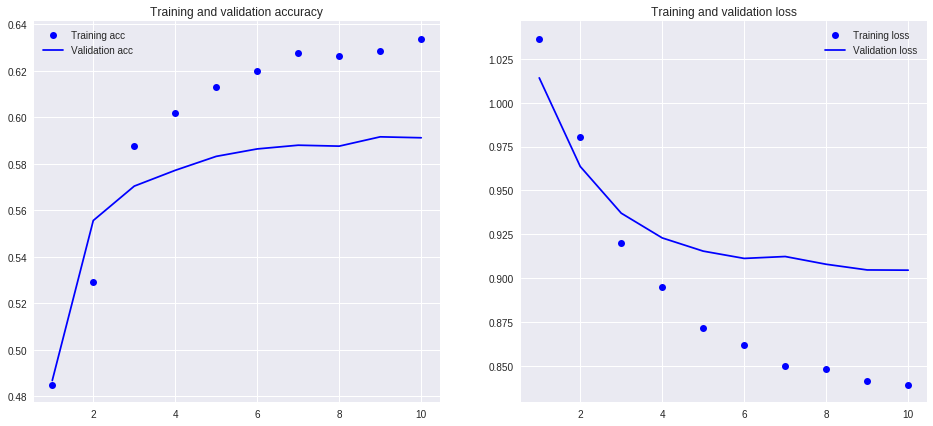

In [0]:
h6 = train_model('6',m6, x_train, one_hot_labels)
plot_history(h6)

In [0]:
del m6
del h6
tf.reset_default_graph()
K.clear_session()

### 5.3. Model with Selected Drug Data

#### 5.3.1. GRU Model for Levonorgestrel Drug

Training the model ...
Train on 2742 samples, validate on 915 samples
Epoch 1/10
2742/2742 [==============================] - 22s 8ms/step - loss: 1.0237 - acc: 0.5408 - val_loss: 0.9842 - val_acc: 0.5486
Epoch 2/10
2742/2742 [==============================] - 21s 8ms/step - loss: 0.9664 - acc: 0.5489 - val_loss: 0.9575 - val_acc: 0.5497
Epoch 3/10
2742/2742 [==============================] - 21s 8ms/step - loss: 0.9261 - acc: 0.5613 - val_loss: 0.9296 - val_acc: 0.5760
Epoch 4/10
2742/2742 [==============================] - 20s 7ms/step - loss: 0.8827 - acc: 0.6014 - val_loss: 0.9016 - val_acc: 0.6044
Epoch 5/10
2742/2742 [==============================] - 21s 8ms/step - loss: 0.8326 - acc: 0.6437 - val_loss: 0.8776 - val_acc: 0.6295
Epoch 6/10
2742/2742 [==============================] - 21s 8ms/step - loss: 0.7992 - acc: 0.6699 - val_loss: 0.8601 - val_acc: 0.6317
Epoch 7/10
2742/2742 [==============================] - 21s 7ms/step - loss: 0.7749 - acc: 0.6761 - val_loss: 0.8418 - v

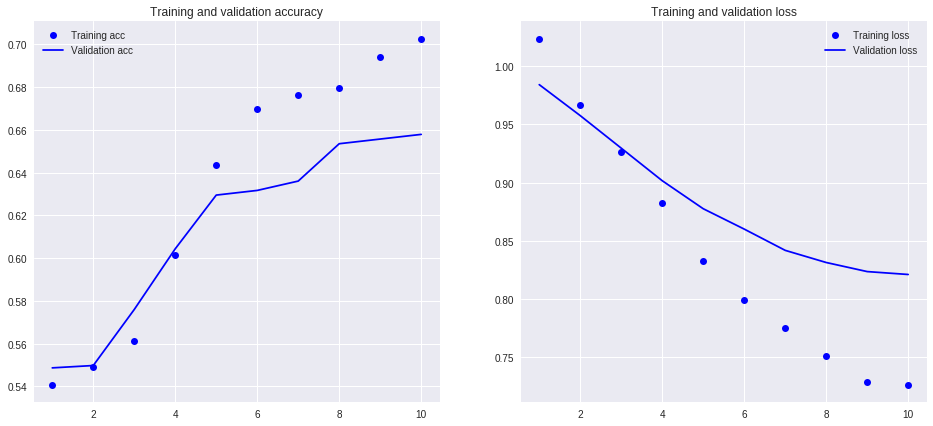

In [0]:
h7 = train_model('7',m7, x_train_levo, one_hot_labels_levo)
plot_history(h7)

In [0]:
del m7
del h7
tf.reset_default_graph()
K.clear_session()

#### 5.3.2. GRU Model for Etonogestrel Drug

Training the model ...
Train on 2502 samples, validate on 834 samples
Epoch 1/10
2502/2502 [==============================] - 20s 8ms/step - loss: 1.0667 - acc: 0.4708 - val_loss: 1.0431 - val_acc: 0.4760
Epoch 2/10
2502/2502 [==============================] - 20s 8ms/step - loss: 1.0321 - acc: 0.4764 - val_loss: 1.0223 - val_acc: 0.4760
Epoch 3/10
2502/2502 [==============================] - 19s 8ms/step - loss: 1.0089 - acc: 0.4832 - val_loss: 0.9983 - val_acc: 0.4988
Epoch 4/10
2502/2502 [==============================] - 19s 8ms/step - loss: 0.9716 - acc: 0.5188 - val_loss: 0.9616 - val_acc: 0.5492
Epoch 5/10
2502/2502 [==============================] - 19s 8ms/step - loss: 0.9237 - acc: 0.5791 - val_loss: 0.9147 - val_acc: 0.5863
Epoch 6/10
2502/2502 [==============================] - 19s 8ms/step - loss: 0.8864 - acc: 0.6107 - val_loss: 0.9038 - val_acc: 0.5851
Epoch 7/10
2502/2502 [==============================] - 19s 8ms/step - loss: 0.8488 - acc: 0.6303 - val_loss: 0.8693 - v

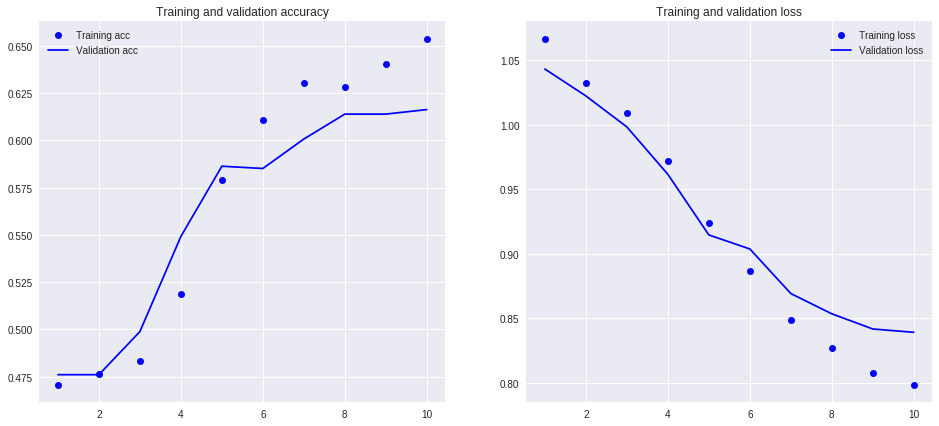

In [0]:
h8 = train_model('8',m8, x_train_eto, one_hot_labels_eto)
plot_history(h8)

In [0]:
del m8
del h8
tf.reset_default_graph()
K.clear_session()

## 6. Evaluation
<br>After training and validation process done, we will check what is the best model we have and use it to test with unseen test dataset.

### 6.1. Validation Comparison between Using Non-preprocessed Data and Preprocessed Data
<hr>
<br>In this section, we will compare the validation loss and validation accuracy between each model when we use non-preprocessed data and use preprocessed data. Here is our result.

In [0]:
# compare model using non-preprocessed data with model using proprecessed data
t = Texttable()
acc = []
for i in score_list:
  accuracy_score = format(np.trace(i[1])/sum(i[1]))
  acc.append(accuracy_score)
t.add_rows([['Model', 'Using non-preprocessed data', 'Using preprocessed data'], 
            ['Conv1D Model', acc[0] ,acc[3] ], 
            ['LSTM Model', acc[1], acc[4]],
            ['GRU Model', acc[2], acc[5]]
           ])
print ('Validation Accuracy Comparison')
print (t.draw())
print ('')

Validation Accuracy Comparison
+--------------+-----------------------------+-------------------------+
|    Model     | Using non-preprocessed data | Using preprocessed data |
+==============+=============================+=========================+
| Conv1D Model | 0.616                       | 0.584                   |
+--------------+-----------------------------+-------------------------+
| LSTM Model   | 0.636                       | 0.604                   |
+--------------+-----------------------------+-------------------------+
| GRU Model    | 0.590                       | 0.591                   |
+--------------+-----------------------------+-------------------------+



### 6.2. Test Scores for Best Selected Model
<hr>
<br>As you can see, the most accurate model we have is absolutely the model Conv1D with preprocessed dataset.

<br>Compared to other models, this model has the highest accuracy score and lower validation loss. So, we choose this model as our model to test with unseen data from testing set.

<br>You may notice the overfitting occurred during the training period, we will discuss about overfitiing later in discussion part.

<br>Again, we will find matrix scores like a confusion matrix, model accuracy, precision, recall, f1-score, and support for this model using test dataset. Here are our code.

In [0]:
# Load final model
loadedmodel = load_model('bestmodel_5.h5')
score = loadedmodel.evaluate(x_test, one_hot_labels_test, batch_size=32)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Print total accuracy and confusion matrix
val_predicts = loadedmodel.predict(x_test)
y_pred = argmax(val_predicts, axis = 1)
labels_test_argmax = argmax(one_hot_labels_test, axis = 1)
cm = confusion_matrix(labels_test_argmax, y_pred)
print('-------------------- Model Scores--------------------')
print('Total accuracy: {:.4f}'.format(np.trace(cm)/sum(cm)))
print('Confusion matrix:')
print(cm)

# Calculate precision, recall, fscore and support
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p, r, f, s = precision_recall_fscore_support(labels_test_argmax, y_pred)

# Print precision, recall, fscore and support  
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print('Support: ', s)
print('Precision:', p)
print('Recall:   ', r)
print('F-score:  ', f)
print('-----------------------------------------------------')

2000/2000 [==============================] - 3s 1ms/step
Test loss: 1.1992476835250854
Test accuracy: 0.446
-------------------- Model Scores--------------------
Total accuracy: 0.4460
Confusion matrix:
[[ 12 262 142]
 [ 25 607 348]
 [ 12 319 273]]
Support:  [416 980 604]
Precision: [ 0.245  0.511  0.358]
Recall:    [ 0.029  0.619  0.452]
F-score:   [ 0.052  0.560  0.399]
-----------------------------------------------------


In the last step, we come up with the model for drug review classification with an estimated accuracy of 44.6%.

## 7. Results and Discussion
<br>In this case study, we performed experiment to build the model to compare accuracy between using preprocesseing techniques to the text data and without using it. 

<br>We also experiment to build the model with only selected drug data to test whether seperate data for each drug will help model accuracy and loss improve or not.

<br>Throughout our experiment, we often faced overfitting problem which we think can be solve by incresing data size and change complexity of our models. We will discuss this topics in the end of the results section.

<br>So, in this section, we will seperate discussion into 3 topics.
1. Discussion about Using Preprocessed Data
2. Discussion about Seperated Model for each Drug
3. Discussion about Overfitting

### 7.1. Discussion about Using Preprocessed Data
<hr>

<br>We use three different model to perform this experiment
- Conv1D model
- LSTM model
- GRU model. 

<br>At first, we believed that with preprocessed text before put into the training data will result in betteraccuracy and lower loss value. There are many preprocessing text techniques we used in this experiment.
- Stemming Words
- Removing Stopwords
- Removing Non-character characters
- Convert to padding sequences

<br>Then we train each model with both non-preprocessed data and preprocessed data to find the validation accuracy. Here is the comparison table.

In [0]:
# compare model using non-preprocessed data with model using proprecessed data
t = Texttable()
acc = []
for i in score_list:
  accuracy_score = format(np.trace(i[1])/sum(i[1]))
  acc.append(accuracy_score)
t.add_rows([['Model', 'Using non-preprocessed data', 'Using preprocessed data'], 
            ['Conv1D Model', acc[0] ,acc[3] ], 
            ['LSTM Model', acc[1], acc[4]],
            ['GRU Model', acc[2], acc[5]]
           ])
print ('Validation Accuracy Comparison')
print (t.draw())
print ('')

Validation Accuracy Comparison
+--------------+-----------------------------+-------------------------+
|    Model     | Using non-preprocessed data | Using preprocessed data |
+==============+=============================+=========================+
| Conv1D Model | 0.616                       | 0.584                   |
+--------------+-----------------------------+-------------------------+
| LSTM Model   | 0.636                       | 0.604                   |
+--------------+-----------------------------+-------------------------+
| GRU Model    | 0.590                       | 0.591                   |
+--------------+-----------------------------+-------------------------+



You can clearly see that, performing preprocessing text didn't help improve accuracy much. We think it's because of the stemming function also make the negative meaning became more positive rather than remain negative. 

<br>For example, word 'didn't', 'did', 'do', and 'don't', when we stemming these word will result in the same word 'do'. 

<br>This is the problem we found when we analyze the stemming function and think that, for text sentiment analysis, stemming word is not the suitable technique for this kind of problem. But we still think that removing stopword still the good practice for build model based on text input data.

### 7.2. Discussion about Seperated Model for each Drug
<hr>

<br>For next experiment, as we stated earlier, we believed that seperating data to train model for each drug individually will result in the better model with higher accuracy and lower loss.

<br>For example, we extract the Levenorgestrel drug review records to the new dataset and train model based on only this drug review. We think it will be better than use all dataset with different kind of drugs mixed together to train our model since the review information also based on type of drugs as well.

<br>So, we experiment by ceate 2 new datasets
- Only Levenorgestrel drug review dataset.
- Only Etonogestrel drug review dataset.

<br>Then, we train model with these 2 new data set using GRU model and compare them with GRU model that train with normal dataset to see accuarcy and loss scores

<br>Here is the table of comparison.



In [0]:
# compare model between seperated drug data model with normal GRU model
t = Texttable()
acc = []
for i in score_list:
  accuracy_score = format(np.trace(i[1])/sum(i[1]))
  acc.append(accuracy_score)
t.add_rows([['Normal GRU model', 'GRU model with only Levenorgestrel drug review dataset', 'GRU model with only Etonogestrel drug review dataset'], 
            [acc[5], acc[6] ,acc[7] ]
           ])
print ('Validation Accuracy Comparison')
print (t.draw())
print ('')

Validation Accuracy Comparison
+------------------+-----------------------------+-----------------------------+
| Normal GRU model |     GRU model with only     |     GRU model with only     |
|                  | Levenorgestrel drug review  |  Etonogestrel drug review   |
|                  |           dataset           |           dataset           |
+==================+=============================+=============================+
| 0.591            | 0.658                       | 0.616                       |
+------------------+-----------------------------+-----------------------------+



As you can see, our assumption is correct. We think that with review data that associated with drug, we should consider drug information as well.

<br>As you can see, when we treat drug information correctly, model accutracy will slightly increase.

### 7.3. Discussion about Overfitting
<hr>

As you noticed, most of the time throughout our experiment, we faced overfitting problem.

<br>We believed overfitting occured due to the data size for training data is not enough. 

<br>In this case study, due to the limitation of time and computing resources, we limit the training data to be only 7500 records, validation data to be only 2500 records, and testing data to be 2000 records. This considered to be very small number of data compare to the original data records (estimately 150000 records).

<br>To prove our assumption, we perform another experiment by using all the model we have used in this case study to perform on the entire dataset we had (150000 records). Here are our results

<br>





In [0]:
# compare model using non-preprocessed data with model using proprecessed data
t = Texttable()
acc = []
for i in score_list:
  accuracy_score = format(np.trace(i[1])/sum(i[1]))
  acc.append(accuracy_score)
t.add_rows([['Model', 'Using 10000 data records', 'Using 150000 data records'], 
            ['Conv1D Model', acc[3] ,"0.8095" ], 
            ['LSTM Model', acc[4], "0.7954"],
            ['GRU Model', acc[5]," 0.7986"]
           ])
print ('Validation Accuracy Comparison')
print (t.draw())
print ('')

Validation Accuracy Comparison
+--------------+--------------------------+---------------------------+
|    Model     | Using 10000 data records | Using 150000 data records |
+==============+==========================+===========================+
| Conv1D Model | 0.584                    | 0.809                     |
+--------------+--------------------------+---------------------------+
| LSTM Model   | 0.604                    | 0.795                     |
+--------------+--------------------------+---------------------------+
| GRU Model    | 0.591                    | 0.799                     |
+--------------+--------------------------+---------------------------+



As you can see, using more data result in better model accuracy and lower lost value. 

The full process and how we perform to train and validate dara can be read on supplementary norebook here.

> LINK TO SUPPLEMENTARY NOTEBOOK FOR CASE 3

You can see on that notebook that the overfitting problem has been solved, our assumption about increasing data size solved overfitting id correct.

## 8. Conclusions

After guessing and trying many times with different methods and models, we have so many models at our hands that can classify drug review rating. Each model we have trained has its own strength and weakness. In this case study, we want to experiment comparing model train with non-preprocessed data and model with preprocessed data to see which one is better and more suitable for this case classification.

<br>Throughout experiments, we learned that preprocessed text with stemming techniques didn't help our models to improve accuracy and loss score. In contrast, it make our model become worse because it remove negative meaning information from our training data. However, our belief that removing stopword and seperate data by drug will increase model accuracy are correct.

<br>We found out that in this experiment, we face overfitting very often. We think that overfitting occured because of lack of enough data so we do another seperate experiment with a huge set of data to see that with enough and very large data, the overfitting problem will be solve or not. And the result claim that our assumption is true, increasing data size definitely improve model accuracy and solve overfitting.

<br>We believe that with more time and computation resources, we can make our model performed better by increasing the size of training data and solve the overfitting problem.


<hr>